# Cohort in Python

This notebook explains how to perform *Cohort Analysis* on customer purchase history data. We are using [pandas](https://pandas.pydata.org) (for data manipulation). Source: http://www.gregreda.com/2015/08/23/cohort-analysis-with-python/

## Understanding the data

The dataset contains both information on purchase data:

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl

pd.set_option('max_columns', 50)
mpl.rcParams['lines.linewidth'] = 2

%matplotlib inline

df = pd.read_excel('data/relay-foods.xlsx')
df.head()

,OrderId,OrderDate,UserId,TotalCharges,CommonId,PupId,PickupDate
0,262,2009-01-11,47,50.67,TRQKD,2,2009-01-12
1,278,2009-01-20,47,26.60,4HH2S,3,2009-01-20
2,294,2009-02-03,47,38.71,3TRDC,2,2009-02-04
3,301,2009-02-06,47,53.38,NGAZJ,2,2009-02-09
4,302,2009-02-06,47,14.28,FFYHD,2,2009-02-09


## Building the cohort

Basically we need to shape the data to create the cohorts. 

### Create a period column based on the OrderDate

In [4]:
df['OrderPeriod'] = df.OrderDate.apply(lambda x: x.strftime('%Y-%m'))
df.head()

,OrderId,OrderDate,UserId,TotalCharges,CommonId,PupId,PickupDate,OrderPeriod
0,262,2009-01-11,47,50.67,TRQKD,2,2009-01-12,2009-01
1,278,2009-01-20,47,26.60,4HH2S,3,2009-01-20,2009-01
2,294,2009-02-03,47,38.71,3TRDC,2,2009-02-04,2009-02
3,301,2009-02-06,47,53.38,NGAZJ,2,2009-02-09,2009-02
4,302,2009-02-06,47,14.28,FFYHD,2,2009-02-09,2009-02


### Determine the user's cohort group (based on their first order)

In [5]:
df.set_index('UserId', inplace=True)

df['CohortGroup'] = df.groupby(level=0)['OrderDate'].min().apply(lambda x: x.strftime('%Y-%m'))
df.reset_index(inplace=True)
df.head()

,UserId,OrderId,OrderDate,TotalCharges,CommonId,PupId,PickupDate,OrderPeriod,CohortGroup
0,47,262,2009-01-11,50.67,TRQKD,2,2009-01-12,2009-01,2009-01
1,47,278,2009-01-20,26.60,4HH2S,3,2009-01-20,2009-01,2009-01
2,47,294,2009-02-03,38.71,3TRDC,2,2009-02-04,2009-02,2009-01
3,47,301,2009-02-06,53.38,NGAZJ,2,2009-02-09,2009-02,2009-01
4,47,302,2009-02-06,14.28,FFYHD,2,2009-02-09,2009-02,2009-01


### Rollup data by CohortGroup & OrderPeriod

In [6]:
grouped = df.groupby(['CohortGroup', 'OrderPeriod'])

# count the unique users, orders, and total revenue per Group + Period
cohorts = grouped.agg({'UserId': pd.Series.nunique,
                       'OrderId': pd.Series.nunique,
                       'TotalCharges': np.sum})

# make the column names more meaningful
cohorts.rename(columns={'UserId': 'TotalUsers',
                        'OrderId': 'TotalOrders'}, inplace=True)
cohorts.head()

TotalUsers  TotalOrders  TotalCharges
CohortGroup OrderPeriod                                       
2009-01     2009-01              22           30      1850.255
            2009-02               8           25      1351.065
            2009-03              10           26      1357.360
            2009-04               9           28      1604.500
            2009-05              10           26      1575.625

### Label the CohortPeriod for each CohortGroup

In [7]:
def cohort_period(df):
    """
    Creates a `CohortPeriod` column, which is the Nth period based on the user's first purchase.
    
    Example
    -------
    Say you want to get the 3rd month for every user:
        df.sort(['UserId', 'OrderTime', inplace=True)
        df = df.groupby('UserId').apply(cohort_period)
        df[df.CohortPeriod == 3]
    """
    df['CohortPeriod'] = np.arange(len(df)) + 1
    return df

cohorts = cohorts.groupby(level=0).apply(cohort_period)
cohorts.head()

TotalUsers  TotalOrders  TotalCharges  CohortPeriod
CohortGroup OrderPeriod                                                     
2009-01     2009-01              22           30      1850.255             1
            2009-02               8           25      1351.065             2
            2009-03              10           26      1357.360             3
            2009-04               9           28      1604.500             4
            2009-05              10           26      1575.625             5

### Make sure we did all that right

In [10]:
x = df[(df.CohortGroup == '2009-01') & (df.OrderPeriod == '2009-01')]
y = cohorts.loc[('2009-01', '2009-01')]

assert(x['UserId'].nunique() == y['TotalUsers'])
assert(x['TotalCharges'].sum().round(2) == y['TotalCharges'].round(2))
assert(x['OrderId'].nunique() == y['TotalOrders'])

x = df[(df.CohortGroup == '2009-01') & (df.OrderPeriod == '2009-09')]
y = cohorts.loc[('2009-01', '2009-09')]

assert(x['UserId'].nunique() == y['TotalUsers'])
assert(x['TotalCharges'].sum().round(2) == y['TotalCharges'].round(2))
assert(x['OrderId'].nunique() == y['TotalOrders'])

x = df[(df.CohortGroup == '2009-05') & (df.OrderPeriod == '2009-09')]
y = cohorts.loc[('2009-05', '2009-09')]

assert(x['UserId'].nunique() == y['TotalUsers'])
assert(x['TotalCharges'].sum().round(2) == y['TotalCharges'].round(2))
assert(x['OrderId'].nunique() == y['TotalOrders'])

## User Retention by Cohort Group

In [11]:
# reindex the DataFrame
cohorts.reset_index(inplace=True)
cohorts.set_index(['CohortGroup', 'CohortPeriod'], inplace=True)

# create a Series holding the total size of each CohortGroup
cohort_group_size = cohorts['TotalUsers'].groupby(level=0).first()
cohort_group_size.head()

CohortGroup
2009-01    22
2009-02    15
2009-03    13
2009-04    39
2009-05    50
Name: TotalUsers, dtype: int64

In [12]:
cohorts['TotalUsers'].head()

CohortGroup  CohortPeriod
2009-01      1               22
             2                8
             3               10
             4                9
             5               10
Name: TotalUsers, dtype: int64

In [13]:
cohorts['TotalUsers'].unstack(0).head()

CohortGroup,2009-01,2009-02,2009-03,2009-04,2009-05,2009-06,2009-07,2009-08,2009-09,2009-10,2009-11,2009-12,2010-01,2010-02,2010-03
CohortPeriod,,,,,,,,,,,,,,,
1,22.0,15.0,13.0,39.0,50.0,32.0,50.0,31.0,37.0,54.0,130.0,65.0,95.0,100.0,24.0
2,8.0,3.0,4.0,13.0,13.0,15.0,23.0,11.0,15.0,17.0,32.0,17.0,50.0,19.0,NaN
3,10.0,5.0,5.0,10.0,12.0,9.0,13.0,9.0,14.0,12.0,26.0,18.0,26.0,NaN,NaN
4,9.0,1.0,4.0,13.0,5.0,6.0,10.0,7.0,8.0,13.0,29.0,7.0,NaN,NaN,NaN
5,10.0,4.0,1.0,6.0,4.0,7.0,11.0,6.0,13.0,13.0,13.0,NaN,NaN,NaN,NaN


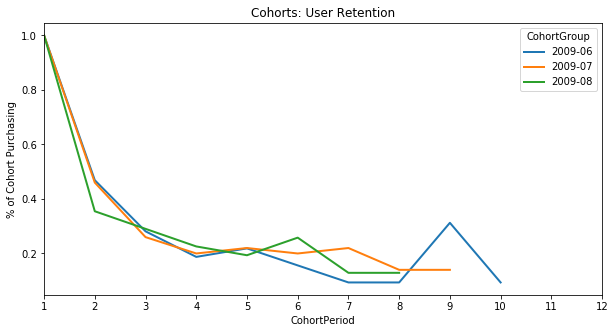

In [14]:
user_retention = cohorts['TotalUsers'].unstack(0).divide(cohort_group_size, axis=1)
user_retention.head(10)
user_retention[['2009-06', '2009-07', '2009-08']].plot(figsize=(10,5))
plt.title('Cohorts: User Retention')
plt.xticks(np.arange(1, 12.1, 1))
plt.xlim(1, 12)
plt.ylabel('% of Cohort Purchasing');

## User Retention using a Heatmap

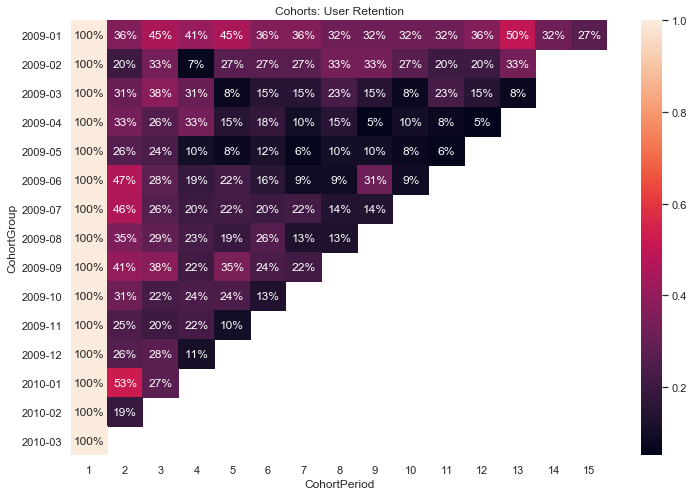

In [15]:
# Creating heatmaps in matplotlib is more difficult than it should be.
# Thankfully, Seaborn makes them easy for us.
# http://stanford.edu/~mwaskom/software/seaborn/

import seaborn as sns
sns.set(style='white')

plt.figure(figsize=(12, 8))
plt.title('Cohorts: User Retention')
sns.heatmap(user_retention.T, mask=user_retention.T.isnull(), annot=True, fmt='.0%');